# Analysis of JFK International Terminal Server Scheduling with Time-based Greedy Optimization with Stochastic Simulation

This notebook walks through an analysis of server scheduling using a time-based greedy optimization method for the JFK airport International arrivals terminal (terminal 4) for both domestic and international passengers for the 24 hours of October 23rd, 2017.  

## Input Data
- [Arrivals to JFK](https://www.airport-jfk.com/arrivals.php)
- [Seat counts](https://www.seatguru.com/)
- [Service distribution assumptions](https://www.cbp.gov/travel/advisories-wait-times)

Data is scrapped, transformed, and loaded into the customs_db.sqlite database with scripts found in the [customs repository](https://www.github.com/citrusvanilla).

## Optimization/Scheduling

Scheduling uses a time-series based greedy optimization algorithm to ensure the capping of the average wait time of an agent in the system while minimizing the overall number of total server hours required. This method reduces the complexity of an exhaustive search for an optimal schedule from an intractable, exponentially-complex problem in O(N^m) to a linearly-complex search for a near-optimal schedule in O(m * N).  Use of momentum in the greedy search further reduces the number of realized simulations by another 30-40%.  Full description can be found in the parent repository README file.

The comparative heuristic schedule compares the same number of total servers hours as the optimized cases, scheduled to match the distribution of arrivals in linear fashion (i.e. assign one server for every 40 arrivals per hour).

## Analysis

Below we present the results of our motivating example. 

In [1]:
from __future__ import print_function

import os
import re
import sqlite3

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sim_dir = os.path.join(os.getcwd(), "output")

# Get a list of simulation directory names.
simulations = [i for i in os.listdir(sim_dir) if not i.startswith('.')]

# Tell iPython to include plots inline in the notebook
%matplotlib inline

## Metadata
Stuff about the sims here.

In [2]:
# Init empty dataframe for output.
logs = pd.DataFrame()

# Define headers.
headers = ["passenger/server type",
           "wait threshold",
           "max available servers",
           "number of optimizations",
           "ave num sims per optimization",
           "ave time per optimization",
           "total simulation time"]

# Retrieve the log CSVs and output simple metadata.
for i, simulation in enumerate(simulations):

    # Get the log file for the sim.
    log = pd.read_csv(os.path.join(sim_dir, simulation, "log.csv"), header=None)
    
    # Get the following sim metrics:
    passenger_type = re.search("^[a-z]+", simulation).group(0)
    threshold = int(re.sub("m","", re.search("[0-9]+m", simulation).group(0)))
    max_servers = int(re.sub("servers","", re.search("[0-9]+servers", simulation).group(0)))
    num_repetitions = len(log)
    ave_num_sims = int(log[1].mean())
    ave_sim_time = int(log[2].mean())
    tot_sim_time = int(num_repetitions * ave_sim_time)
    
    # Make a pandas series from the data and concatenate.
    metadata = pd.Series([passenger_type,
                          str(threshold) + "m",
                          max_servers,
                          num_repetitions,
                          ave_num_sims,
                          str(ave_sim_time/60) + "m",
                          str(tot_sim_time/3600) + "h"],
                         index = headers,
                         name = "sim_" + str(i+1))

    logs = pd.concat([logs, metadata], axis=1)

In [3]:
# Output metadata.
logs

,sim_1,sim_2,sim_3,sim_4,sim_5,sim_6,sim_7,sim_8
ave num sims per optimization,116,106,108,105,214,171,174,165
ave time per optimization,7m,5m,8m,6m,13m,9m,7m,5m
max available servers,20,20,15,15,50,40,40,40
number of optimizations,100,100,100,100,100,100,100,100
passenger/server type,dom,dom,dom,dom,foreign,foreign,foreign,foreign
total simulation time,13h,8h,13h,10h,21h,15h,12h,9h
wait threshold,20m,30m,40m,50m,20m,30m,40m,50m


## Best Schedules

We choose one simulation here for demonstration purposes.

We load the results of repeated simulations into a temporary table in a database, run the summary queries and display the resultant optimized schedule and comparative heuristic schedule.

In [4]:
# Grab a sample domestic and foreign directory for analysis.
sim = simulations[0]

sample_dir = os.path.join("output", sim)

# Use the customs db, or another for temporary SQL querying.
tmp_db = "tmp_db.sqlite"
connection = sqlite3.connect(tmp_db)
cursor = connection.cursor()

cursor.execute("DROP TABLE if exists optimized;")
cursor.execute("DROP TABLE if exists heuristic;")

# Create temporary tables.
cursor.execute('CREATE TABLE optimized '
                    '(idx integer primary key, '
                    'hour integer, '
                    'count integer, '
                    'ave_wait real, '
                    'max_wait real, '
                    'ave_server_utilization real, '
                    'num_servers integer);')

cursor.execute('CREATE TABLE heuristic '
                    '(idx integer primary key, '
                    'hour integer, '
                    'count integer, '
                    'ave_wait real, '
                    'max_wait real, '
                    'ave_server_utilization real, '
                    'num_servers integer);')

# Read in the raw results from CSV to pandas dataframes.
tmp_opt = pd.read_csv(os.path.join(sample_dir, "optimized_models.csv"))
tmp_heur = pd.read_csv(os.path.join(sample_dir, "heuristic_models.csv"))

# Insert raw results into database
tmp_opt.to_sql('optimized', connection, if_exists='replace')
tmp_heur.to_sql('heuristic', connection, if_exists='replace')

# Perform summary SQL queries.
data_opt = pd.read_sql('SELECT cast(hour as int) as hour, '
                               'cast(avg(ave_wait) as int) as OPT_ave_wait, '
                               'cast(avg(max_wait) as int) as OPT_max_wait, '
                               'avg(ave_server_utilization) as OPT_ave_server_util, '
                               'avg(num_servers) as OPT_num_servers '
                           'FROM optimized '
                           'WHERE hour != \'hour\''
                           'GROUP by hour '
                           'ORDER BY cast(hour as integer)', connection)

data_heur = pd.read_sql('SELECT cast(hour as integer) as hour, '
                                'cast(avg(ave_wait) as int) as HEUR_ave_wait, '
                                'cast(avg(max_wait) as int) as HEUR_max_wait, '
                                'avg(ave_server_utilization) as HEUR_ave_server_util, '
                                'avg(num_servers) as HEUR_num_servers '
                            'FROM heuristic '
                            'WHERE hour != \'hour\''
                            'GROUP BY hour '
                            'ORDER BY cast(hour as integer)', connection)

# Clean-up and close database connection.
cursor.execute("DROP TABLE optimized;")
cursor.execute("DROP TABLE heuristic;")

connection.close()

# Merge dataframes for comparitive analysis.
data_comp = data_opt.merge(data_heur, left_on='hour', right_on='hour', how='outer')
cols = data_comp.columns.tolist()
data_comp = data_comp[[cols[0], cols[4], cols[8], cols[1], cols[5], cols[2], cols[6], cols[3], cols[7]]]

print("Schedule for ", sim, ".", sep = "")
data_comp

Schedule for dom_20m_20servers.


,hour,OPT_num_servers,HEUR_num_servers,OPT_ave_wait,HEUR_ave_wait,OPT_max_wait,HEUR_max_wait,OPT_ave_server_util,HEUR_ave_server_util
0,0,4.00,4.78,17,13,35,29,0.7500,0.7022
1,1,2.18,1.00,16,33,31,55,0.6858,0.8752
2,2,4.07,3.00,18,26,37,66,0.7016,0.7749
3,3,2.00,1.00,16,26,32,44,0.4200,0.8628
4,5,4.47,6.00,16,10,31,22,0.8300,0.7555
5,6,5.48,7.00,17,12,36,32,0.7566,0.5818
6,7,4.93,3.97,16,19,30,35,0.7615,0.6999
7,8,7.97,6.00,18,49,38,90,0.1880,0.3786
8,9,7.29,2.00,6,37,16,46,0.6168,1.0000
9,10,4.17,5.00,18,35,33,59,0.7187,1.0000


## Comparative Analysis

Plot shit here.

### Average Wait Times, Optimized Schedule vs. Linear Heuristic

Optimized customs schedule: 
Average wait: 16.2380952381 minutes
Standard deviation: 2.70008818198 minutes.
Num. hours in which a passenger's average wait exceeds threshold: 0

Heuristic customs schedule: 
Average wait: 20.2380952381 minutes
Standard deviation: 11.9117788844 minutes.
Num. hours in which a passenger's average wait exceeds threshold: 5


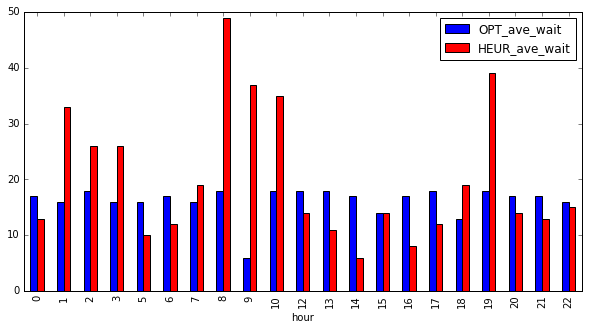

In [5]:
print("Optimized customs schedule: \n",
      "Average wait: ", data_comp['OPT_ave_wait'].mean(), " minutes\n",
      "Standard deviation: ", data_comp['OPT_ave_wait'].std(), " minutes.\n",
      "Num. hours in which a passenger's average wait exceeds threshold: ",
      (data_comp['OPT_ave_wait'] > 30).sum(), "\n", sep= "")

print("Heuristic customs schedule: \n",
      "Average wait: ", data_comp['HEUR_ave_wait'].mean(), " minutes\n",
      "Standard deviation: ", data_comp['HEUR_ave_wait'].std(), " minutes.\n",
      "Num. hours in which a passenger's average wait exceeds threshold: ",  (data_comp['HEUR_ave_wait'] > 30).sum(), sep= "")

data_comp.plot(x='hour', figsize = (10,5), y=['OPT_ave_wait', 'HEUR_ave_wait'], kind = 'bar', color=('b','r'))

### Maximum Wait Times, Optimized Schedule vs. Linear Heuristic

Optimized customs schedule: 
Maximum wait time: 38 minutes
Num. hours in which a passenger's average wait exceeds 2x threshold: 0

Heuristic customs schedule: 
Maximum wait time: 90 minutes
Num. hours in which a passenger's average wait exceeds 2x threshold: 2


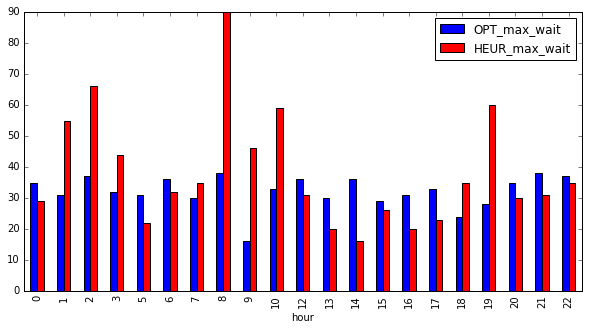

In [6]:
print("Optimized customs schedule: \n",
      "Maximum wait time: ", data_comp['OPT_max_wait'].max(), " minutes\n",
      "Num. hours in which a passenger's average wait exceeds 2x threshold: ",
      (data_comp['OPT_max_wait'] > 60).sum(), "\n", sep= "")

print("Heuristic customs schedule: \n",
      "Maximum wait time: ", data_comp['HEUR_max_wait'].max(), " minutes\n",
      "Num. hours in which a passenger's average wait exceeds 2x threshold: ",
      (data_comp['HEUR_max_wait'] > 60).sum(), sep= "")

data_comp.plot(x='hour', figsize = (10,5), y=['OPT_max_wait', 'HEUR_max_wait'], kind = 'bar', color=('b','r'))

### Number of Servers, Optimized Schedule vs. Linear Heuristic

Optimized customs schedule: 
Total scheduled servers: 152

Heuristic customs schedule: 
Total scheduled servers: 149



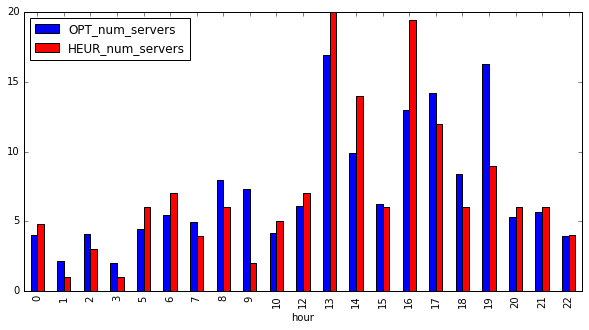

In [7]:
print("Optimized customs schedule: \n",
      "Total scheduled servers: ", int(data_comp['OPT_num_servers'].sum()),
      "\n", sep= "")

print("Heuristic customs schedule: \n",
      "Total scheduled servers: ", int(data_comp['HEUR_num_servers'].sum()),
      "\n", sep= "")


data_comp.plot(x='hour', figsize = (10,5), y=['OPT_num_servers', 'HEUR_num_servers'], kind = 'bar', color=('b','r'))

### Server Utilization, Optimized Schedule vs. Linear Heuristic

Optimized customs schedule: 
Average server utilization: 0.733514285714
Num. hours in which server utilization is 1: 2

Heuristic customs schedule: 
Average server utilization: 0.770619047619
Num. hours in which a passenger's average wait exceeds 2x threshold: 3


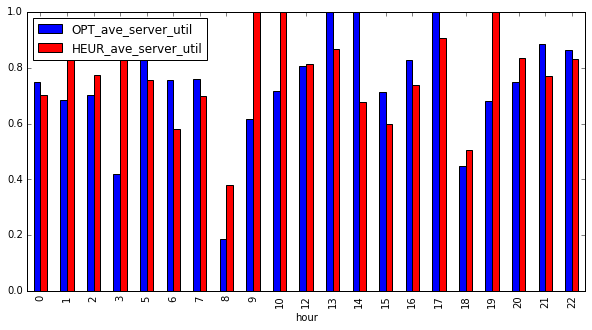

In [8]:
print("Optimized customs schedule: \n",
      "Average server utilization: ", data_comp['OPT_ave_server_util'].mean(), "\n",
      "Num. hours in which server utilization is 1: ",
      (data_comp['OPT_ave_server_util'] == 1).sum(), "\n", sep= "")

print("Heuristic customs schedule: \n",
      "Average server utilization: ", data_comp['HEUR_ave_server_util'].mean(), "\n",
      "Num. hours in which a passenger's average wait exceeds 2x threshold: ",
      (data_comp['HEUR_ave_server_util'] == 1).sum(), sep= "")

data_comp.plot(x='hour', figsize = (10,5), y=['OPT_ave_server_util', 'HEUR_ave_server_util'], kind = 'bar', color=('b','r'))